# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                  
Sample_070  Q9ULP0-3;Q9ULP0-6                                  13.946
Sample_082  E7EN28;E7ESV6;E7ETE3;E7EUP0;E7EUW2;E7EVD6;E7EX52   16.407
Sample_094  A0A0B4J1Y8                                         16.679
Sample_091  O75173;O75173-2;Q5VTW1                             17.723
Sample_010  Q09327                                             15.195
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups                 
Sample_171  Q15459;Q15459-2                   14.941
Sample_008  Q5JRA6;Q5JRA6-2                   15.163
Sample_108  J3KQG3;Q5JZY3;Q5JZY3-2;Q5JZY3-3   16.226
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.903
            A0A075B6Q5                 12.233
            A0A075B6R2                 14.064
            A0A075B6S5                 13.802
            A0A087WSY4                 13.065
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.479
            Q9UI40;Q9UI40-2            11.770
            Q9UIW2                     11.322
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.979
            Q9UP79                     13.260
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.071,15.050,16.842,19.863,15.651,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.664,19.067,...,15.528,15.576,13.928,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.555,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,16.150,17.705,17.039,16.345,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.861,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.800,15.345,17.084,18.708,14.249,19.433,11.976,10.982
Sample_207,15.739,16.877,15.469,16.898,14.683,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.302,11.790,11.439,12.860,12.623,13.817,11.755,12.796,12.225,13.540
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.367,19.067,16.127,...,11.494,13.737,13.857,11.847,12.505,12.136,12.209,13.108,13.116,12.348
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.266,13.292,12.578,12.467,13.010,13.474,12.896,13.423,11.865,10.860
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.284,11.891,12.476,12.791,13.765,13.953,12.428,12.836,12.174,13.997
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.694,12.868,12.831,12.525,13.517,12.814,13.247,12.789,13.445,13.386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.841,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 345.92it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.78it/s]

100%|██████████| 2/2 [00:00<00:00,  5.74it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.86it/s]

100%|██████████| 3/3 [00:00<00:00,  5.94it/s]

100%|██████████| 3/3 [00:00<00:00,  6.22it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.26it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.69it/s]

100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

100%|██████████| 4/4 [00:00<00:00,  4.91it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.15it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.14it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.07it/s]

100%|██████████| 5/5 [00:01<00:00,  3.44it/s]

100%|██████████| 5/5 [00:01<00:00,  3.90it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.20it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.84it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.47it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.27it/s]

100%|██████████| 6/6 [00:01<00:00,  3.41it/s]

100%|██████████| 6/6 [00:01<00:00,  3.56it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.65it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.66it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.29it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.16it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.31it/s]

100%|██████████| 7/7 [00:02<00:00,  2.56it/s]

100%|██████████| 7/7 [00:02<00:00,  2.50it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.01it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.59it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.06it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.82it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.73it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.64it/s]

100%|██████████| 8/8 [00:02<00:00,  2.44it/s]

100%|██████████| 8/8 [00:02<00:00,  2.77it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.59it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.27it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.50it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.01it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.89it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.01it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.01it/s]

100%|██████████| 9/9 [00:02<00:00,  4.14it/s]

100%|██████████| 9/9 [00:02<00:00,  4.30it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.90it/s]

 30%|███       | 3/10 [00:00<00:01,  5.54it/s]

 40%|████      | 4/10 [00:00<00:01,  5.66it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.62it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.53it/s]

 70%|███████   | 7/10 [00:01<00:00,  5.15it/s]

 80%|████████  | 8/10 [00:01<00:00,  5.62it/s]

 90%|█████████ | 9/10 [00:01<00:00,  5.97it/s]

100%|██████████| 10/10 [00:01<00:00,  6.14it/s]

100%|██████████| 10/10 [00:01<00:00,  5.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.93it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.12it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.28it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.08it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.25it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.00it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.18it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.25it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.44it/s]

100%|██████████| 11/11 [00:02<00:00,  4.43it/s]

100%|██████████| 11/11 [00:02<00:00,  4.62it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 11.72it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.81it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.57it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.60it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.53it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.54it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.61it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.61it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.69it/s]

100%|██████████| 12/12 [00:02<00:00,  4.48it/s]

100%|██████████| 12/12 [00:02<00:00,  4.86it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.04it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.28it/s]

 31%|███       | 4/13 [00:01<00:02,  3.54it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.35it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.20it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.81it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.65it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.59it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.70it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.90it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.91it/s]

100%|██████████| 13/13 [00:04<00:00,  3.16it/s]

100%|██████████| 13/13 [00:04<00:00,  3.12it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.88it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.52it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.44it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.32it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.36it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.28it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.71it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.56it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.67it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.82it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.94it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.84it/s]

100%|██████████| 14/14 [00:03<00:00,  3.51it/s]

100%|██████████| 14/14 [00:03<00:00,  3.91it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.11it/s]

 20%|██        | 3/15 [00:00<00:02,  4.88it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.88it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.38it/s]

 40%|████      | 6/15 [00:01<00:02,  3.18it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.07it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.21it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.22it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.10it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.43it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.50it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.71it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.67it/s]

100%|██████████| 15/15 [00:04<00:00,  3.71it/s]

100%|██████████| 15/15 [00:04<00:00,  3.58it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.040 0.011          0.801 0.316       0.122   
2             0.005 0.004      0.054 0.018          0.651 0.173       0.306   
3             0.004 0.003      0.046 0.024          0.740 0.105       0.675   
4             0.005 0.004      0.051 0.020          0.705 0.092       0.689   
5             0.004 0.003      0.051 0.019          0.794 0.105       0.709   
6             0.003 0.000      0.035 0.002          0.808 0.086       0.775   
7             0.005 0.003      0.061 0.030          0.829 0.077       0.782   
8             0.007 0.007      0.068 0.033          0.833 0.079       0.783   
9             0.004 0.000      0.037 0.010          0.825 0.086       0.830   
10            0.003 0.001      0.023 0.005          0.834 0.084       0.828   
11            0.004 0.001      0.037 0.006          0.837 0.077       0.833   
12            0.004 0.002      0.036 0.009          0.839 0.072       0.832   
13            0.004 0.000      0.035 0.003          0.832 0.076       0.829   
14            0.004 0.003      0.043 0.016          0.834 0.076       0.824   
15            0.004 0.002      0.044 0.017          0.826 0.084       0.812   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.081   0.204 0.122                  0.554 0.039        0.856   
2          0.101   0.402 0.100                  0.584 0.052        0.724   
3          0.113   0.701 0.091                  0.749 0.072        0.829   
4          0.116   0.691 0.086                  0.738 0.069        0.831   
5          0.122   0.741 0.089                  0.783 0.069        0.883   
6          0.105   0.787 0.076                  0.819 0.064        0.913   
7          0.099   0.801 0.071                  0.831 0.058        0.917   
8          0.092   0.803 0.068                  0.833 0.056        0.916   
9          0.094   0.824 0.073                  0.849 0.064        0.925   
10         0.092   0.827 0.070                  0.852 0.060        0.925   
11         0.092   0.831 0.065                  0.856 0.055        0.924   
12         0.095   0.832 0.065                  0.857 0.055        0.924   
13         0.102   0.826 0.069                  0.852 0.059        0.922   
14         0.101   0.825 0.070                  0.851 0.060        0.921   
15         0.086   0.816 0.068                  0.842 0.058        0.925   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.823 0.088        210.000 0.000  
2          0.083                  0.646 0.106        210.000 0.000  
3          0.065                  0.785 0.094        210.000 0.000  
4          0.061                  0.775 0.090        210.000 0.000  
5          0.055                  0.837 0.077        210.000 0.000  
6          0.044                  0.884 0.059        210.000 0.000  
7          0.046                  0.888 0.063        210.000 0.000  
8          0.048                  0.887 0.065        210.000 0.000  
9          0.043                  0.906 0.051        210.000 0.000  
10         0.044                  0.905 0.054        210.000 0.000  
11         0.043                  0.901 0.056        210.000 0.000  
12         0.043                  0.902 0.056        210.000 0.000  
13         0.043                  0.899 0.056        210.000 0.000  
14         0.045                  0.898 0.058        210.000 0.000  
15         0.043                  0.906 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 454.42it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

100%|██████████| 2/2 [00:00<00:00,  5.91it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.34it/s]

100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

100%|██████████| 3/3 [00:00<00:00,  5.24it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.33it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.05it/s]

100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.21it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.41it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.05it/s]

100%|██████████| 5/5 [00:01<00:00,  2.62it/s]

100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.70it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.18it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.69it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.33it/s]

100%|██████████| 6/6 [00:01<00:00,  4.24it/s]

100%|██████████| 6/6 [00:01<00:00,  4.58it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.09it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.15it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.17it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.02it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.19it/s]

100%|██████████| 7/7 [00:01<00:00,  4.46it/s]

100%|██████████| 7/7 [00:01<00:00,  4.53it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.72it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.18it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.42it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.23it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.20it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.07it/s]

100%|██████████| 8/8 [00:01<00:00,  4.03it/s]

100%|██████████| 8/8 [00:01<00:00,  4.35it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.66it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.04it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.46it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.39it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.29it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.14it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.05it/s]

100%|██████████| 9/9 [00:02<00:00,  3.92it/s]

100%|██████████| 9/9 [00:02<00:00,  4.30it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.97it/s]

 30%|███       | 3/10 [00:00<00:01,  4.98it/s]

 40%|████      | 4/10 [00:00<00:01,  4.30it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.16it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.02it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.98it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.03it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.92it/s]

100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.43it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.84it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.40it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.13it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.89it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.25it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.07it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  3.92it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.86it/s]

100%|██████████| 11/11 [00:02<00:00,  3.98it/s]

100%|██████████| 11/11 [00:02<00:00,  4.45it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.70it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.67it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.18it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.76it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.73it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.44it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.29it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.30it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.41it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.64it/s]

100%|██████████| 12/12 [00:03<00:00,  3.67it/s]

100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.19it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.88it/s]

 31%|███       | 4/13 [00:00<00:02,  4.22it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.06it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.89it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.95it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.90it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.55it/s]

 77%|███████▋  | 10/13 [00:02<00:01,  3.00it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.75it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.68it/s]

100%|██████████| 13/13 [00:03<00:00,  2.63it/s]

100%|██████████| 13/13 [00:03<00:00,  3.31it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.18it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.91it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.80it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.70it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.85it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.93it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  4.00it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  4.16it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.05it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.08it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.11it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  4.14it/s]

100%|██████████| 14/14 [00:03<00:00,  4.34it/s]

100%|██████████| 14/14 [00:03<00:00,  4.10it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.17it/s]

 20%|██        | 3/15 [00:00<00:02,  4.99it/s]

 27%|██▋       | 4/15 [00:00<00:03,  3.54it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.10it/s]

 40%|████      | 6/15 [00:01<00:03,  2.79it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.67it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.73it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.85it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.89it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.70it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.94it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.22it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.38it/s]

100%|██████████| 15/15 [00:04<00:00,  3.34it/s]

100%|██████████| 15/15 [00:04<00:00,  3.17it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.044 0.016          0.000 0.000       0.000   
2             0.004 0.002      0.040 0.011          0.753 0.135       0.433   
3             0.004 0.003      0.045 0.018          0.690 0.098       0.595   
4             0.005 0.004      0.052 0.022          0.688 0.100       0.596   
5             0.006 0.007      0.050 0.021          0.758 0.100       0.702   
6             0.004 0.002      0.046 0.016          0.802 0.094       0.788   
7             0.004 0.003      0.042 0.019          0.797 0.093       0.779   
8             0.005 0.004      0.046 0.016          0.788 0.088       0.783   
9             0.005 0.005      0.052 0.022          0.780 0.092       0.768   
10            0.004 0.003      0.041 0.014          0.796 0.093       0.746   
11            0.005 0.003      0.044 0.018          0.798 0.094       0.749   
12            0.003 0.002      0.030 0.009          0.804 0.087       0.785   
13            0.004 0.000      0.035 0.006          0.811 0.090       0.787   
14            0.004 0.002      0.049 0.021          0.802 0.089       0.784   
15            0.005 0.003      0.043 0.019          0.802 0.084       0.784   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.859   
2          0.114   0.541 0.109                  0.663 0.062        0.692   
3          0.114   0.634 0.091                  0.699 0.068        0.783   
4          0.106   0.634 0.087                  0.698 0.067        0.777   
5          0.095   0.724 0.074                  0.766 0.060        0.830   
6          0.103   0.789 0.071                  0.820 0.059        0.901   
7          0.111   0.782 0.074                  0.814 0.063        0.900   
8          0.107   0.780 0.071                  0.812 0.060        0.900   
9          0.111   0.769 0.077                  0.803 0.065        0.897   
10         0.111   0.764 0.075                  0.800 0.061        0.909   
11         0.113   0.766 0.075                  0.802 0.062        0.908   
12         0.101   0.790 0.072                  0.821 0.061        0.917   
13         0.107   0.794 0.074                  0.825 0.062        0.918   
14         0.101   0.788 0.067                  0.819 0.056        0.915   
15         0.098   0.788 0.066                  0.819 0.056        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.831 0.086        210.000 0.000  
2          0.094                  0.668 0.106        210.000 0.000  
3          0.068                  0.732 0.096        210.000 0.000  
4          0.069                  0.726 0.098        210.000 0.000  
5          0.058                  0.793 0.078        210.000 0.000  
6          0.046                  0.877 0.055        210.000 0.000  
7          0.046                  0.873 0.057        210.000 0.000  
8          0.049                  0.871 0.061        210.000 0.000  
9          0.049                  0.871 0.059        210.000 0.000  
10         0.045                  0.882 0.058        210.000 0.000  
11         0.045                  0.880 0.058        210.000 0.000  
12         0.044                  0.895 0.051        210.000 0.000  
13         0.043                  0.896 0.051        210.000 0.000  
14         0.045                  0.892 0.053        210.000 0.000  
15         0.043                  0.898 0.050 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1044.66it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 27.68it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 16.98it/s]

100%|██████████| 3/3 [00:00<00:00, 16.73it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 21.03it/s]

100%|██████████| 4/4 [00:00<00:00, 18.12it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 25.55it/s]

100%|██████████| 5/5 [00:00<00:00, 16.40it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 19.90it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 15.38it/s]

100%|██████████| 6/6 [00:00<00:00, 16.26it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 19.69it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 15.10it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 14.22it/s]

100%|██████████| 7/7 [00:00<00:00, 14.31it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 23.32it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 16.60it/s]

100%|██████████| 8/8 [00:00<00:00, 16.08it/s]

100%|██████████| 8/8 [00:00<00:00, 16.68it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 20.44it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 14.57it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 14.26it/s]

100%|██████████| 9/9 [00:00<00:00, 14.46it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 26.12it/s]

 60%|██████    | 6/10 [00:00<00:00, 17.97it/s]

 80%|████████  | 8/10 [00:00<00:00, 15.10it/s]

100%|██████████| 10/10 [00:00<00:00, 13.05it/s]

100%|██████████| 10/10 [00:00<00:00, 14.63it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 21.34it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 15.38it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 13.97it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.36it/s]

100%|██████████| 11/11 [00:00<00:00, 14.36it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 23.80it/s]

 50%|█████     | 6/12 [00:00<00:00, 13.86it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 12.45it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 12.06it/s]

100%|██████████| 12/12 [00:00<00:00, 12.08it/s]

100%|██████████| 12/12 [00:00<00:00, 12.66it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 18.92it/s]

 38%|███▊      | 5/13 [00:00<00:00, 15.18it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 16.23it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 14.79it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 14.32it/s]

100%|██████████| 13/13 [00:00<00:00, 14.45it/s]

100%|██████████| 13/13 [00:00<00:00, 14.75it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 21.41it/s]

 43%|████▎     | 6/14 [00:00<00:00, 13.08it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 12.14it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 12.14it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 12.11it/s]

100%|██████████| 14/14 [00:01<00:00, 12.47it/s]

100%|██████████| 14/14 [00:01<00:00, 12.69it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 20.53it/s]

 40%|████      | 6/15 [00:00<00:00, 11.80it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 11.54it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 11.34it/s]

 80%|████████  | 12/15 [00:01<00:00, 11.44it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 11.39it/s]

100%|██████████| 15/15 [00:01<00:00, 11.75it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.039 0.013          0.000 0.000       0.000   
2             0.004 0.003      0.055 0.021          0.633 0.156       0.332   
3             0.004 0.002      0.036 0.007          0.609 0.103       0.471   
4             0.004 0.003      0.049 0.018          0.639 0.092       0.529   
5             0.004 0.002      0.039 0.008          0.651 0.096       0.536   
6             0.006 0.005      0.056 0.021          0.719 0.095       0.605   
7             0.004 0.001      0.038 0.007          0.724 0.099       0.614   
8             0.005 0.004      0.051 0.019          0.731 0.105       0.618   
9             0.004 0.000      0.040 0.011          0.720 0.093       0.602   
10            0.005 0.004      0.048 0.018          0.720 0.108       0.622   
11            0.004 0.002      0.039 0.008          0.725 0.103       0.600   
12            0.005 0.003      0.044 0.016          0.714 0.101       0.603   
13            0.004 0.001      0.038 0.006          0.720 0.109       0.601   
14            0.008 0.006      0.070 0.028          0.706 0.100       0.587   
15            0.004 0.002      0.040 0.012          0.717 0.101       0.612   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.731   
2          0.104   0.425 0.106                  0.591 0.060        0.641   
3          0.088   0.524 0.075                  0.622 0.053        0.718   
4          0.096   0.575 0.081                  0.655 0.058        0.757   
5          0.091   0.584 0.083                  0.663 0.060        0.750   
6          0.110   0.652 0.091                  0.715 0.067        0.790   
7          0.118   0.659 0.098                  0.720 0.074        0.782   
8          0.114   0.665 0.097                  0.725 0.074        0.779   
9          0.104   0.649 0.080                  0.713 0.059        0.791   
10         0.110   0.661 0.085                  0.719 0.067        0.794   
11         0.104   0.651 0.085                  0.714 0.066        0.793   
12         0.107   0.649 0.087                  0.711 0.068        0.790   
13         0.105   0.649 0.088                  0.712 0.070        0.789   
14         0.108   0.636 0.086                  0.702 0.066        0.785   
15         0.105   0.655 0.083                  0.715 0.065        0.791   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.071                  0.685 0.086        210.000 0.000  
2          0.070                  0.612 0.074        210.000 0.000  
3          0.064                  0.692 0.072        210.000 0.000  
4          0.069                  0.717 0.079        210.000 0.000  
5          0.072                  0.704 0.085        210.000 0.000  
6          0.070                  0.761 0.083        210.000 0.000  
7          0.076                  0.757 0.087        210.000 0.000  
8          0.076                  0.753 0.088        210.000 0.000  
9          0.070                  0.764 0.079        210.000 0.000  
10         0.066                  0.763 0.079        210.000 0.000  
11         0.063                  0.761 0.080        210.000 0.000  
12         0.065                  0.761 0.081        210.000 0.000  
13         0.066                  0.762 0.082        210.000 0.000  
14         0.066                  0.760 0.079        210.000 0.000  
15         0.065                  0.763 0.079 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,8,5,14
score_time,8,9,14
test_precision,12,13,8
test_recall,11,6,10
test_f1,12,13,8
test_balanced_accuracy,12,13,8
test_roc_auc,15,15,10
test_average_precision,15,15,9
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.43it/s]

 20%|██        | 3/15 [00:00<00:02,  4.46it/s]

 27%|██▋       | 4/15 [00:00<00:03,  3.60it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.31it/s]

 40%|████      | 6/15 [00:01<00:02,  3.15it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.17it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.20it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.80it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.58it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.45it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.39it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.75it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.93it/s]

100%|██████████| 15/15 [00:04<00:00,  2.98it/s]

100%|██████████| 15/15 [00:04<00:00,  3.02it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 20.34it/s]

 60%|██████    | 6/10 [00:00<00:00, 16.54it/s]

 80%|████████  | 8/10 [00:00<00:00, 15.90it/s]

100%|██████████| 10/10 [00:00<00:00, 14.93it/s]

100%|██████████| 10/10 [00:00<00:00, 15.64it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.88it/s]

 20%|██        | 3/15 [00:00<00:03,  3.36it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.88it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.66it/s]

 40%|████      | 6/15 [00:02<00:03,  2.58it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.51it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.60it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.60it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.76it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.94it/s]

 80%|████████  | 12/15 [00:04<00:00,  3.17it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.21it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.28it/s]

100%|██████████| 15/15 [00:05<00:00,  3.20it/s]

100%|██████████| 15/15 [00:05<00:00,  2.98it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


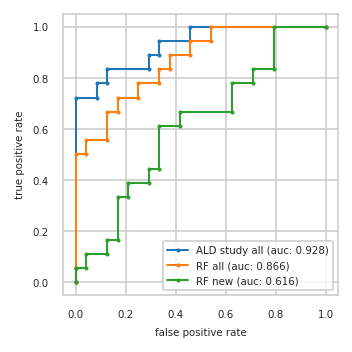

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.722  0.000 0.500  0.042 0.056
3          0.083 0.722  0.042 0.500  0.042 0.111
4          0.083 0.778  0.042 0.556  0.125 0.111
5          0.125 0.778  0.125 0.556  0.125 0.167
6          0.125 0.833  0.125 0.667  0.167 0.167
7          0.292 0.833  0.167 0.667  0.167 0.333
8          0.292 0.889  0.167 0.722  0.208 0.333
9          0.333 0.889  0.250 0.722  0.208 0.389
10         0.333 0.944  0.250 0.778  0.292 0.389
11         0.458 0.944  0.333 0.778  0.292 0.444
12         0.458 1.000  0.333 0.833  0.333 0.444
13         1.000 1.000  0.375 0.833  0.333 0.611
14           NaN   NaN  0.375 0.889  0.417 0.611
15           NaN   NaN  0.458 0.889  0.417 0.667
16           NaN   NaN  0.458 0.944  0.625 0.667
17           NaN   NaN  0.542 0.944  0.625 0.778
18           NaN   NaN  0.542 1.000  0.708 0.778
19           NaN   NaN  1.000 1.000  0.708 0.833
20           NaN   NaN    NaN   NaN  0.792 0.833
21           NaN   NaN    NaN   NaN  0.792 1.000
22           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q15848,Q8NFY4;Q8NFY4-6,E5RK69;E7EMC6;P08133;P08133-2
2,P09960;P09960-4,A0A0B4J2B5;S4R460,P10745
3,P61981,P04075,Q16799
4,P14174,Q9Y2T3;Q9Y2T3-3,P31321
5,P04075,P61981,E9PK25;G3V1A4;P23528
6,P00338;P00338-3,P15151-2,A0A075B7B8
7,Q9Y2T3;Q9Y2T3-3,P14174,Q96GD0
8,P08294,Q14894,A0A0C4DGV4;E9PLX3;O43504;R4GMU8


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


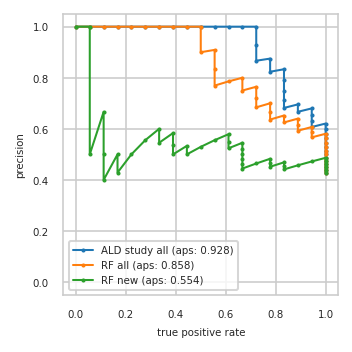

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.441 0.833
9          0.545 1.000     0.545 1.000     0.455 0.833
10         0.562 1.000     0.562 1.000     0.469 0.833
11         0.581 1.000     0.581 1.000     0.452 0.778
12         0.600 1.000     0.567 0.944     0.467 0.778
13         0.621 1.000     0.586 0.944     0.483 0.778
14         0.607 0.944     0.607 0.944     0.464 0.722
15         0.630 0.944     0.593 0.889     0.444 0.667
16         0.654 0.944     0.615 0.889     0.462 0.667
17         0.680 0.944     0.640 0.889     0.480 0.667
18         0.667 0.889     0.625 0.833     0.500 0.667
19         0.696 0.889     0.652 0.833     0.522 0.667
20         0.682 0.833     0.636 0.778     0.545 0.667
21         0.714 0.833     0.667 0.778     0.524 0.611
22         0.750 0.833     0.700 0.778     0.550 0.611
23         0.789 0.833     0.684 0.722     0.579 0.611
24         0.833 0.833     0.722 0.722     0.556 0.556
25         0.824 0.778     0.765 0.722     0.529 0.500
26         0.875 0.778     0.750 0.667     0.500 0.444
27         0.867 0.722     0.800 0.667     0.533 0.444
28         0.929 0.722     0.786 0.611     0.500 0.389
29         1.000 0.722     0.769 0.556     0.538 0.389
30         1.000 0.667     0.833 0.556     0.583 0.389
31         1.000 0.611     0.909 0.556     0.545 0.333
32         1.000 0.556     0.900 0.500     0.600 0.333
33         1.000 0.500     1.000 0.500     0.556 0.278
34         1.000 0.444     1.000 0.444     0.500 0.222
35         1.000 0.389     1.000 0.389     0.429 0.167
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


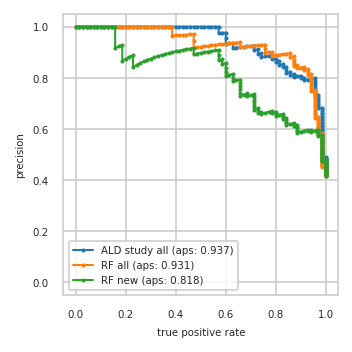

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


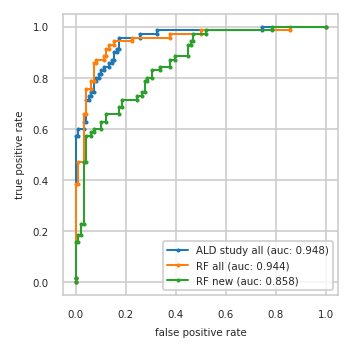

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}